## Diagnóstico de doenças cardiovasculares usandoMachine Learning

O objeto desse trabalho é analisar um dataset com dados reais de pacientes, treinar um modelo baseado nas caracteriscas dos pacientes e criar um modelo que consegue prever se um paciente tem doença cardiovascular.

In [1]:
# Importa todas as bibliotecas que serão utilizadas no projeto
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [2]:
df = pd.read_csv("heart-disease.csv")
df.shape #(linhas, colunas)

(303, 14)

In [3]:
df.head() #sample do dataset

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


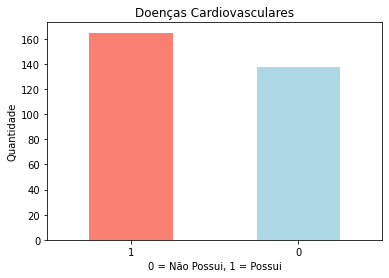

In [4]:
# Gráfico da quantidade de pacientes com e sem doença cardiovascular
target_index = {0:"Não possui",1:"Possui"}
df.target.value_counts().plot(kind="bar", color=["salmon", "lightblue"])

plt.title("Doenças Cardiovasculares")
plt.xlabel("0 = Não Possui, 1 = Possui")
plt.ylabel("Quantidade")
plt.xticks(rotation=0);

In [5]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


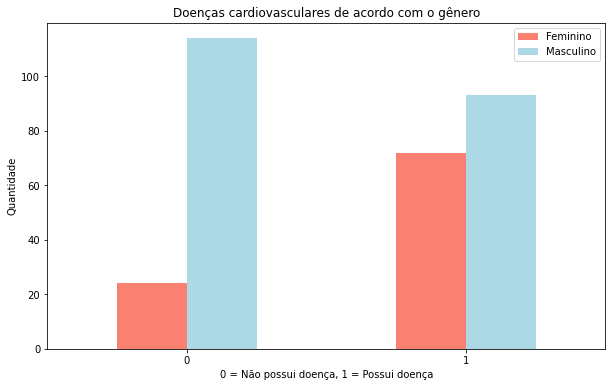

In [6]:
# Gráfico de doenças cardiovasculares de acordo com o gênero
pd.crosstab(df.target, df.sex).plot(kind="bar", figsize=(10,6), color=["salmon", "lightblue"])

plt.title("Doenças cardiovasculares de acordo com o gênero")
plt.xlabel("0 = Não possui doença, 1 = Possui doença")
plt.ylabel("Quantidade")
plt.legend(["Feminino", "Masculino"])
plt.xticks(rotation=0);

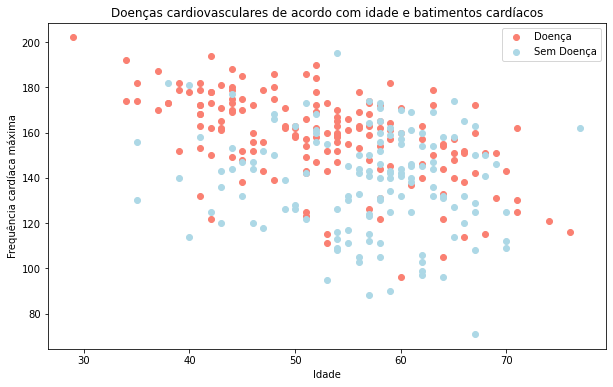

In [7]:
#Gráfico de Doenças cardiovasculares de acordo com idade e batimentos cardíacos
plt.figure(figsize=(10,6))
plt.scatter(df.age[df.target==1], 
            df.thalach[df.target==1], 
            c="salmon")

plt.scatter(df.age[df.target==0], 
            df.thalach[df.target==0], 
            c="lightblue")

plt.title("Doenças cardiovasculares de acordo com idade e batimentos cardíacos")
plt.xlabel("Idade")
plt.legend(["Doença", "Sem Doença"])
plt.ylabel("Frequência cardíaca máxima");

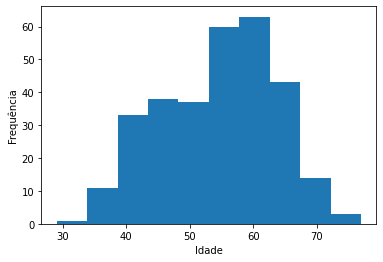

In [8]:
#Distribuição de idade
df.age.plot.hist()
plt.ylabel("Frequência")
plt.xlabel("Idade");

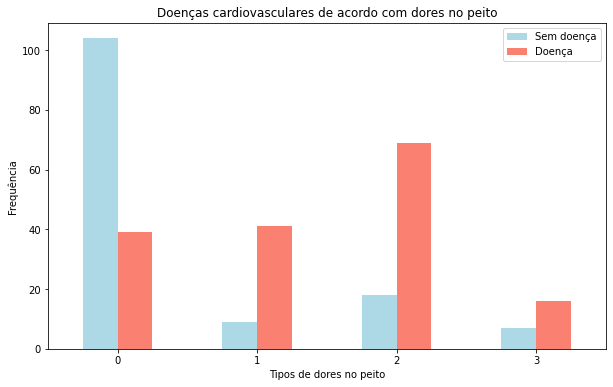

In [9]:
#Gráfico de doenças cardiovasculares de acordo com dores no peito
pd.crosstab(df.cp, df.target).plot(kind="bar", 
                                   figsize=(10,6), 
                                   color=["lightblue", "salmon"])

plt.title("Doenças cardiovasculares de acordo com dores no peito")
plt.xlabel("Tipos de dores no peito")
plt.ylabel("Frequência")
plt.legend(["Sem doença", "Doença"])
plt.xticks(rotation = 0);

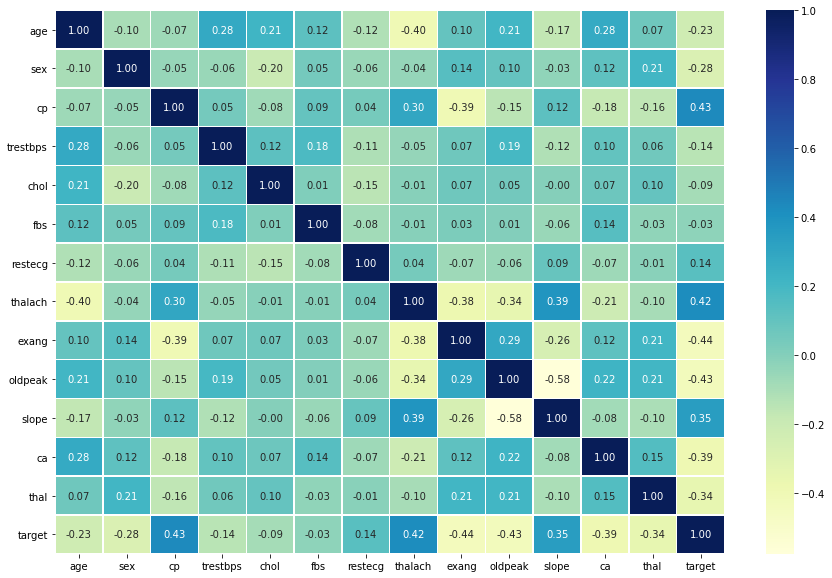

In [10]:
#Matriz de correlação
corr_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu");

In [11]:
# Remove a coluna target
X = df.drop("target", axis=1)

# Dados de target
y = df.target.values

np.random.seed(42)
# Divide treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Cria dicionário com os algortimos classificadores
models = {"Random Forest": RandomForestClassifier(),
          "KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(),           
         }

# Função para execução dos classificadores
def score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [12]:
model_scores = score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

C:\Users\Diogo\TCC\dev\env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Random Forest': 0.8360655737704918,
 'KNN': 0.6885245901639344,
 'Logistic Regression': 0.8852459016393442}

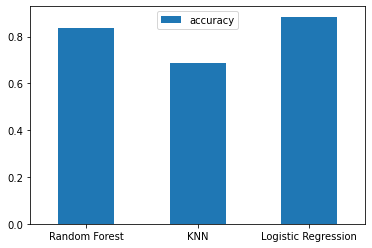

In [13]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar()
plt.xticks(rotation=0);

In [15]:
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)
gs_log_reg.fit(X_train, y_train);


Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [16]:
accuracy = gs_log_reg.score(X_test, y_test)
print(f"accuracy = {accuracy}")

accuracy = 0.8852459016393442


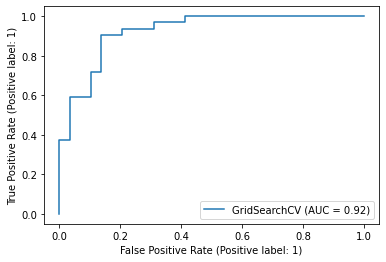

In [17]:
# Gera a curva ROC e calcula AUC
plot_roc_curve(gs_log_reg, X_test, y_test);

In [18]:
# Realiza predição nos dados de testes
y_preds = gs_log_reg.predict(X_test)

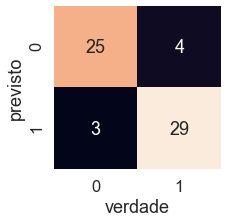

In [19]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.xlabel("verdade")
    plt.ylabel("previsto")
    
plot_conf_mat(y_test, y_preds)

In [20]:
# Exibe o relatório de classificação
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



In [21]:
# Verifica o melhor hiperparâmetro encontrado no Grid Search
gs_log_reg.best_params_

{'C': 0.23357214690901212, 'solver': 'liblinear'}

In [22]:
# Executa a função de cross validation em cada métrica e tira média do resultado
clf = LogisticRegression(C=0.23357214690901212, solver="liblinear")
scoring = {"accuracy","precision","recall","f1"}
cv_score = {}
for score in scoring:
    cv = cross_val_score(clf,
                             X,
                             y,
                             cv=5, #fold cross-validation
                             scoring=score)
    cv_score[score] = np.mean(cv)

In [23]:
cv_score

{'f1': 0.8705403543192143,
 'accuracy': 0.8479781420765027,
 'recall': 0.9272727272727274,
 'precision': 0.8215873015873015}

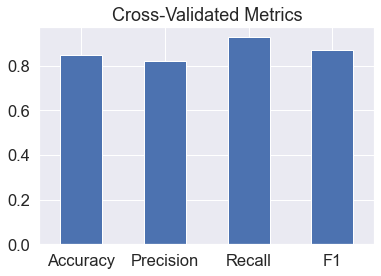

In [24]:
# Gráfico do Cross Validation
cv_metrics = pd.DataFrame({"Accuracy": cv_score["accuracy"],
                            "Precision": cv_score["precision"],
                            "Recall": cv_score["recall"],
                            "F1": cv_score["f1"]},
                          index=[0])
cv_metrics.T.plot.bar(title="Cross-Validated Metrics", legend=False)
plt.xticks(rotation=0);

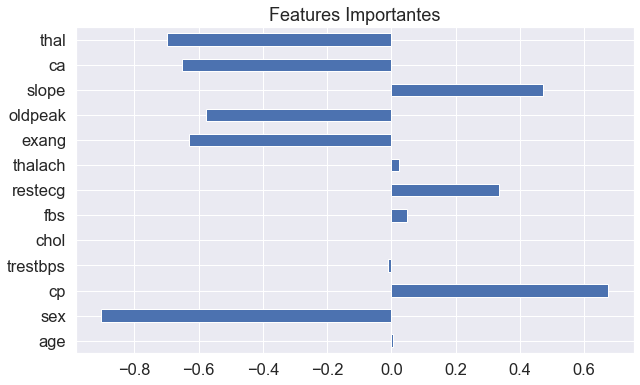

In [25]:
# Utiliza o mesmo objeto chamado anteriormente de Regressão Logistica
clf.fit(X_train, y_train);

# Vincula o coeficiente de importância com as colunas do dataset
features_dict = dict(zip(df.columns, list(clf.coef_[0])))

# Gráfico das features mais importantes
features_df = pd.DataFrame(features_dict, index=[0])
features_df.T.plot.barh(title="Features Importantes", legend=False,figsize=(10,6));